# Supervised LDA with ADVI (Fast Variational Inference)

This notebook uses **ADVI (Automatic Differentiation Variational Inference)** instead of MCMC for faster model fitting. This is useful for:

- **Quick prototyping** and testing model functionality
- **Hypothesis exploration** before running full MCMC
- **Large datasets** where MCMC is too slow

## ADVI vs MCMC Trade-offs

| Aspect | ADVI | MCMC (NUTS) |
|--------|------|-------------|
| **Speed** | ~30 seconds | ~10-15 minutes |
| **Posterior** | Approximate (Gaussian) | Exact samples |
| **Uncertainty** | May underestimate | Accurate |
| **Multi-modal** | May miss modes | Explores all modes |
| **Use case** | Exploration, large data | Final analysis, publication |

**Recommendation**: Use ADVI for initial exploration, then run MCMC for final results.

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom modules
from preprocessing import load_wsev_data, prepare_slda_inputs, train_test_split_stratified
from slda_model import CoPathologySLDA
from visualization import (
    plot_topic_heatmap,
    plot_patient_topic_distribution,
    plot_topic_diagnosis_association,
    plot_brain_topic_pattern,
    plot_copathology_mixtures,
    plot_confusion_matrix
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# Load the WSEV dataset
data_path = '/home/coder/data/updated_WSEV/260108_wsev_final_df.csv'
df = load_wsev_data(data_path)

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"\nDiagnosis distribution:")
print(df['DX'].value_counts())

Loaded 209 patients from /home/coder/data/updated_WSEV/260108_wsev_final_df.csv
Columns: 113

Dataset shape: (209, 113)

Diagnosis distribution:
DX
PD      56
AD      55
HC      49
DLB     28
SVAD    21
Name: count, dtype: int64


In [3]:
# Prepare data for sLDA
X, y, feature_names, dx_labels = prepare_slda_inputs(df, standardize=False)

print(X)
print(feature_names)
print(f"\nFeature matrix X: {X.shape}")
print(f"Diagnosis labels y: {y.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Diagnoses: {dx_labels}")

HC: 49 subjects
Patients: 160 subjects
Diagnosis distribution:
  AD: 55 patients (class 0)
  DLB: 28 patients (class 1)
  PD: 56 patients (class 2)
  SVAD: 21 patients (class 3)

Final data shape:
  X: (160, 62) (patients × cortical regions)
  y: (160,) (patients,)
  Features: 62
  Diagnoses: 4
[[0.86460595 0.08464506 0.8359743  ... 1.61878273 1.87822796 0.28571483]
 [0.         0.03302765 0.96851126 ... 0.75861452 0.72248617 0.        ]
 [0.17460999 0.47923564 0.22402605 ... 0.         0.         0.        ]
 ...
 [2.25933945 2.7967472  0.20443328 ... 1.23489226 0.         1.7670162 ]
 [0.05097786 0.         0.         ... 0.         0.         0.95641123]
 [1.33212118 1.43225643 0.98749254 ... 0.85709687 0.57628411 1.40932972]]
['ctx_lh_caudalanteriorcingulate', 'ctx_lh_caudalmiddlefrontal', 'ctx_lh_cuneus', 'ctx_lh_entorhinal', 'ctx_lh_fusiform', 'ctx_lh_inferiorparietal', 'ctx_lh_inferiortemporal', 'ctx_lh_isthmuscingulate', 'ctx_lh_lateraloccipital', 'ctx_lh_lateralorbitofrontal',

In [4]:
# Use full dataset
X_model, y_model = X, y

## 2. Model Training with ADVI

ADVI optimizes a variational approximation to the posterior. It's much faster than MCMC but provides an approximate (Gaussian) posterior.

In [6]:
# Initialize model
model = CoPathologySLDA(
    n_topics=10,           # Number of latent pathology patterns
    alpha_prior=1.0,      # Dirichlet concentration (1.0 = uniform)
    feature_prior_std=1.0, # Prior std for topic-region weights
    random_state=42
)

print("Model initialized with 10 topics")
print("\nUsing ADVI - this should take ~30-60 seconds...")

Model initialized with 10 topics

Using ADVI - this should take ~30-60 seconds...


In [7]:
%%time

# Fit the model using ADVI
# model.fit(
#     X_model, 
#     y_model,
#     inference='advi',        # Use variational inference
#     n_advi_iterations=30000, # Optimization iterations
#     n_samples=1000           # Samples from approximate posterior
# )

# model.fit(
#     X_model, 
#     y_model,
#     inference='advi',
#     n_advi_iterations=10000,
#     n_samples=1000
# )

model.fit(
    X_model, 
    y_model,
    inference='advi',
    n_advi_iterations=5000,
    n_samples=1000
)

Fitting sLDA model:
  Patients: 160
  Features: 62
  Topics: 10
  Diagnoses: 4
  Inference: ADVI (Variational)
  Iterations: 5000, then 1000 samples

Starting ADVI optimization...


Output()

Finished [100%]: Average Loss = 16,275



ADVI optimization complete! Final ELBO: 14918.73
Drawing 1000 samples from approximate posterior...

ADVI Diagnostics:
  Final ELBO: 14918.73
  ELBO change (last 100 iters): -996.23
  (Warning: ELBO may not have converged - consider more iterations)

Parameter estimates (posterior mean +/- std):
  beta: mean=0.7845, std=0.6838
  theta: mean=0.1000, std=0.0974
  eta: mean=-0.0133, std=1.1377
  sigma_x: mean=1.1896, std=0.4081
CPU times: user 2h 35min 24s, sys: 4min 11s, total: 2h 39min 36s
Wall time: 1h 56min 58s


## 3. Check ADVI Convergence

The ELBO (Evidence Lower Bound) should stabilize as optimization converges.

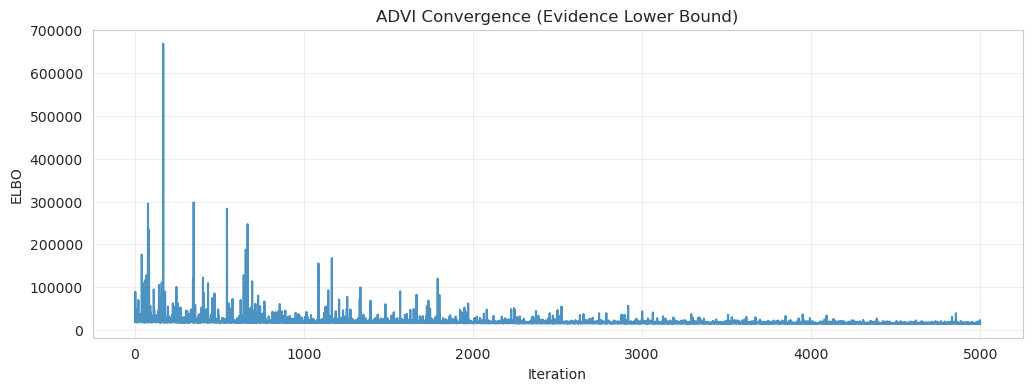

In [8]:
# Plot ELBO convergence
fig = model.plot_elbo(figsize=(12, 4), save_path='advi_elbo.png')
plt.show()

## 4. Extract Model Parameters

In [9]:
# Get posterior means
topic_patterns = model.get_topic_patterns()        # (n_topics, n_features)
patient_mixtures = model.get_patient_mixtures()    # (n_patients, n_topics)
diagnosis_weights = model.get_diagnosis_weights()  # (n_topics, n_classes)

print(f"Topic patterns (beta): {topic_patterns.shape}")
print(f"Patient mixtures (theta): {patient_mixtures.shape}")
print(f"Diagnosis weights (eta): {diagnosis_weights.shape}")

# Verify topic mixtures sum to 1
print(f"\nPatient mixture sums (should be ~1.0): {patient_mixtures[0].sum():.4f}")

Topic patterns (beta): (10, 62)
Patient mixtures (theta): (160, 10)
Diagnosis weights (eta): (10, 4)

Patient mixture sums (should be ~1.0): 1.0000


## 5. Visualize Topic Patterns

Saved to /home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_topic_heatmap.png


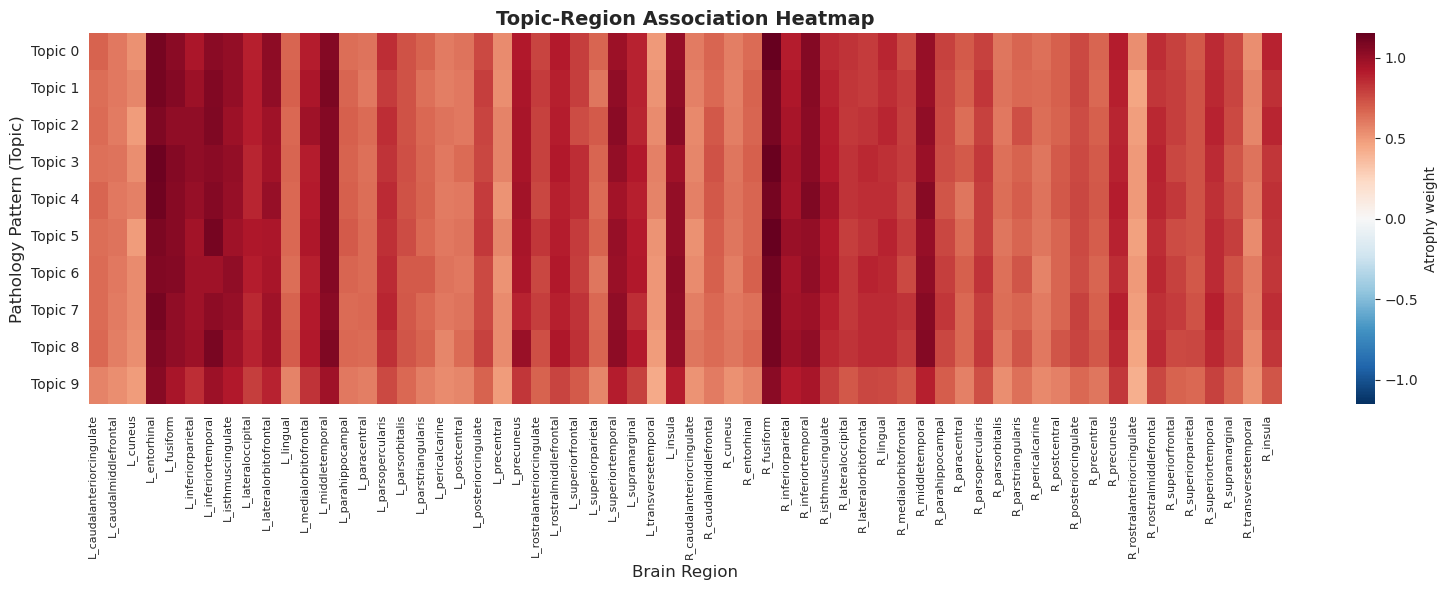

In [13]:
fig = plot_topic_heatmap(
    topic_patterns, 
    feature_names,
    figsize=(16, 6),
    save_path='/home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_topic_heatmap.png'
)
plt.show()

In [14]:
# Print top regions for each topic
for topic_id in range(model.n_topics):
    print(f"\n{'='*60}")
    print(f"Topic {topic_id} - Top 10 Regions")
    print(f"{'='*60}")
    
    top_regions = model.get_topic_top_regions(
        topic_id, 
        feature_names, 
        n_regions=10,
        absolute=True
    )
    
    for i, (region, weight) in enumerate(top_regions, 1):
        print(f"{i:2d}. {region:40s} {weight:+.3f}")


Topic 0 - Top 10 Regions
 1. ctx_rh_fusiform                          +1.151
 2. ctx_lh_entorhinal                        +1.104
 3. ctx_lh_middletemporal                    +1.061
 4. ctx_rh_inferiortemporal                  +1.057
 5. ctx_lh_inferiortemporal                  +1.043
 6. ctx_lh_fusiform                          +1.040
 7. ctx_lh_lateralorbitofrontal              +1.029
 8. ctx_lh_isthmuscingulate                  +1.008
 9. ctx_rh_middletemporal                    +1.004
10. ctx_lh_insula                            +1.000

Topic 1 - Top 10 Regions
 1. ctx_lh_entorhinal                        +1.100
 2. ctx_rh_fusiform                          +1.095
 3. ctx_lh_middletemporal                    +1.082
 4. ctx_lh_inferiortemporal                  +1.065
 5. ctx_lh_fusiform                          +1.054
 6. ctx_rh_inferiortemporal                  +1.045
 7. ctx_lh_superiortemporal                  +1.018
 8. ctx_lh_lateralorbitofrontal              +1.017
 9. ctx_lh_i

## 6. Patient Topic Mixtures

Saved to /home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_patient_topic_distribution.png


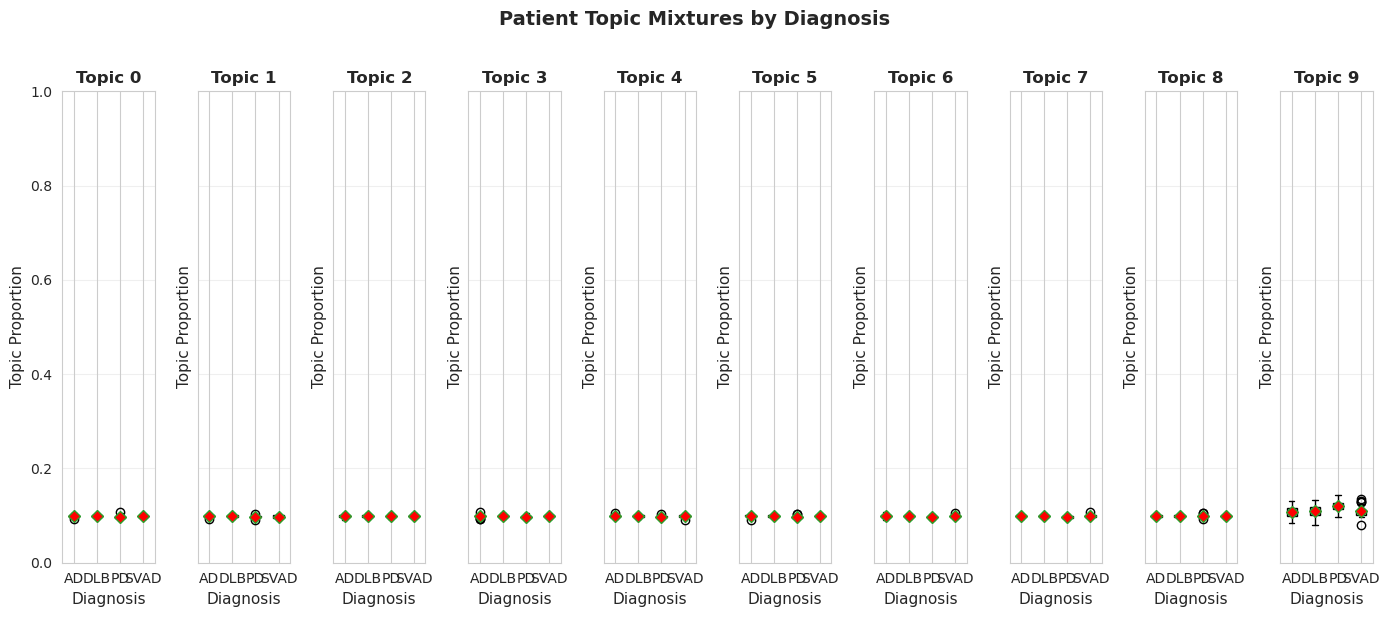

In [15]:
fig = plot_patient_topic_distribution(
    patient_mixtures,
    y_model,
    dx_labels,
    figsize=(14, 6),
    save_path='/home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_patient_topic_distribution.png'
)
plt.show()

## 7. Topic-Diagnosis Associations

Saved to /home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_topic_diagnosis_association.png


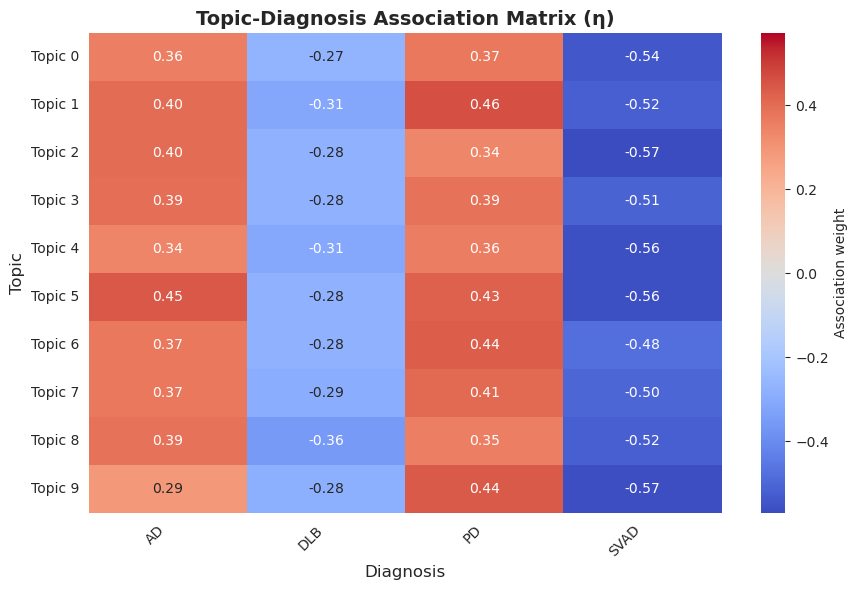

In [16]:
fig = plot_topic_diagnosis_association(
    diagnosis_weights,
    dx_labels,
    figsize=(9, 6),
    save_path='/home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_topic_diagnosis_association.png'
)
plt.show()

In [17]:
# Interpret topic-diagnosis associations
print("Topic-Diagnosis Associations (eta matrix):\n")
print(f"{'Topic':<10}", end="")
for dx in dx_labels:
    print(f"{dx:>10}", end="")
print("\n" + "="*60)

for topic_id in range(model.n_topics):
    print(f"Topic {topic_id:<4}", end="")
    for dx_id in range(len(dx_labels)):
        weight = diagnosis_weights[topic_id, dx_id]
        print(f"{weight:>10.3f}", end="")
    print()

print("\nInterpretation:")
print("- Positive weights: Topic increases probability of diagnosis")
print("- Negative weights: Topic decreases probability of diagnosis")

Topic-Diagnosis Associations (eta matrix):

Topic             AD       DLB        PD      SVAD
Topic 0        0.356    -0.268     0.372    -0.545
Topic 1        0.399    -0.315     0.463    -0.520
Topic 2        0.401    -0.280     0.338    -0.572
Topic 3        0.394    -0.276     0.386    -0.511
Topic 4        0.342    -0.309     0.359    -0.559
Topic 5        0.446    -0.280     0.427    -0.562
Topic 6        0.372    -0.277     0.435    -0.480
Topic 7        0.375    -0.294     0.408    -0.500
Topic 8        0.386    -0.355     0.353    -0.521
Topic 9        0.289    -0.284     0.441    -0.565

Interpretation:
- Positive weights: Topic increases probability of diagnosis
- Negative weights: Topic decreases probability of diagnosis


## 8. Model Predictions

In [18]:
# Predict diagnoses for training data
y_pred = model.predict_diagnosis(X_model)
y_pred_proba = model.predict_diagnosis_proba(X_model)

print(f"Predicted diagnoses shape: {y_pred.shape}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

Predicted diagnoses shape: (160,)
Prediction probabilities shape: (160, 4)


/home/coder/sLDA_co_pathology/slda_model.py:431: UserWarning: Prediction uses point estimates (posterior means) and does not account for full posterior uncertainty. For proper Bayesian prediction, use posterior predictive sampling.
  warnings.warn(
/home/coder/sLDA_co_pathology/slda_model.py:431: UserWarning: Prediction uses point estimates (posterior means) and does not account for full posterior uncertainty. For proper Bayesian prediction, use posterior predictive sampling.
  warnings.warn(


Saved to /home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_confusion_matrix.png


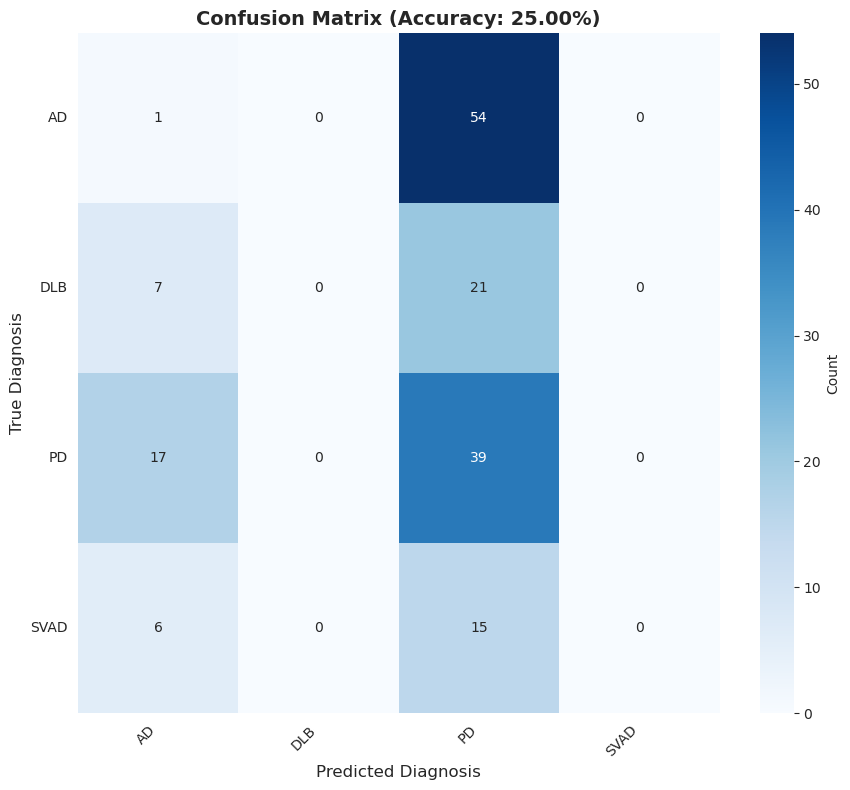

In [19]:
# Plot confusion matrix
fig = plot_confusion_matrix(
    y_model,
    y_pred,
    dx_labels,
    figsize=(9, 8),
    save_path='/home/coder/sLDA_co_pathology/figures/jupyter_advi/advi_confusion_matrix.png'
)
plt.show()

In [20]:
# Per-class accuracy
from sklearn.metrics import classification_report

print("Classification Report (ADVI):\n")
print(classification_report(y_model, y_pred, target_names=dx_labels))

Classification Report (ADVI):

              precision    recall  f1-score   support

          AD       0.03      0.02      0.02        55
         DLB       0.00      0.00      0.00        28
          PD       0.30      0.70      0.42        56
        SVAD       0.00      0.00      0.00        21

    accuracy                           0.25       160
   macro avg       0.08      0.18      0.11       160
weighted avg       0.12      0.25      0.16       160



/home/coder/miniconda3/envs/slda_model/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/coder/miniconda3/envs/slda_model/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/coder/miniconda3/envs/slda_model/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

## 9. Summary

### What we learned from ADVI

ADVI provides a quick approximation that can help you:
1. **Verify the model runs** without errors
2. **Get rough topic patterns** to check if they make biological sense
3. **Estimate classification performance** before investing in full MCMC
4. **Tune hyperparameters** (n_topics, alpha) quickly

### When to use full MCMC

For final analysis, run the original notebook with MCMC to get:
- Accurate uncertainty estimates
- Proper R-hat convergence diagnostics
- Full posterior distributions for credible intervals

### Comparing ADVI vs MCMC results

If ADVI and MCMC give very different results, this may indicate:
- The posterior is multi-modal (ADVI may miss modes)
- ADVI's Gaussian approximation is too restrictive
- More ADVI iterations are needed